# 04: スペクトラルクラスタリング (Spectral Clustering)

このノートブックでは、グラフ理論の考え方を用いてクラスタリングを行う、非常に強力で柔軟な手法である「スペクトラルクラスタリング」について学びます。
この手法は、データを点（ノード）と、点間の類似度を重みとする辺（エッジ）で構成される「グラフ」とみなし、そのグラフの特性（スペクトル）を利用してクラスタリングを行います。

K-meansやGMMが苦手とする、凸でない（非球形な）クラスタ構造を発見する能力に長けているのが大きな特徴です。ここでは、Ng, Jordan, Weiss (2002) によって提案された、標準的で広く用いられているアルゴリズムを中心に解説します。

**参考論文:**
*   (Spectral Clustering) Ng, A. Y., Jordan, M. I., & Weiss, Y. (2002). On spectral clustering: Analysis and an algorithm. In *Advances in neural information processing systems 14 (NIPS 2001)*.

**このノートブックで学ぶこと:**
1.  スペクトラルクラスタリングの基本的な考え方：データをグラフとして表現する。
2.  アルゴリズムの主要な構成要素：類似度行列、ラプラシアン行列、固有値分解。
3.  Ng, Jordan, Weiss (NJW) アルゴリズムのステップごとの解説。
4.  NumPyを用いたNJWアルゴリズムのスクラッチ実装。
5.  なぜ低次元の固有ベクトル空間に射影するとクラスタリングが容易になるのか。
6.  同心円状のデータなど、他の手法では困難なデータに対するスペクトラルクラスタリングの適用例。

**前提知識:**
*   グラフ理論の基礎（ノード、エッジ、隣接行列）。
*   線形代数の基礎（固有値、固有ベクトル）。
*   K-meansクラスタリングのアルゴリズム。
*   NumPyによるベクトル・行列演算。


## 1. 必要なライブラリのインポート

今回は、最終ステップのクラスタリングにK-meansを利用します。

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles, make_moons
from sklearn.cluster import KMeans

## 2. スペクトラルクラスタリングの理論

スペクトラルクラスタリングは、データポイントをグラフのノードとみなし、グラフをうまく分割する（Graph Cut）問題としてクラスタリングを捉えます。目標は、「クラスタ内の辺の重みは大きく、クラスタ間の辺の重みは小さくなる」ような分割を見つけることです。

このグラフカット問題を直接解くのはNP困難ですが、その緩和問題が**ラプラシアン行列の固有値問題**を解くことに帰着することが知られています。これにより、元々の高次元空間では分離が難しいデータでも、固有ベクトルが張る低次元の「スペクトル空間」に射影することで、K-meansのような単純な手法で容易に分離できるようになります。

### 2.1 NJW (Ng-Jordan-Weiss) アルゴリズム

Ng, Jordan, Weissによって提案された標準的なアルゴリズムは、以下のステップで構成されます。

1.  **類似度行列 (Affinity Matrix) の構築**:
    データポイント間の類似度を表す行列 $A$ を構築します。各要素 $A_{ij}$ は、点 $\boldsymbol{x}_i$ と $\boldsymbol{x}_j$ の類似度を示します。一般的には、ガウシアンカーネル（RBFカーネル）が用いられます。
    $$
    A_{ij} = \exp\left(-\frac{||\boldsymbol{x}_i - \boldsymbol{x}_j||^2}{2\sigma^2}\right) \quad (\text{if } i \neq j), \quad A_{ii} = 0
    $$
    ここで、$\sigma$ はカーネルの幅を制御するハイパーパラメータです。

2.  **正規化ラプラシアン行列 (Normalized Laplacian) の構築**:
    グラフの構造を捉えるために、ラプラシアン行列 $L$ を計算します。NJWアルゴリズムでは、正規化されたラプラシアン $L_{sym}$ を用います。  
    a.  まず、次数行列 (Degree Matrix) $D$ を計算します。これは、$A$ の各行の和を対角成分に持つ対角行列です。
        $$ D_{ii} = \sum_{j=1}^{N} A_{ij} $$
    b.  正規化ラプラシアン $L_{sym}$ を計算します。
        $$ L_{sym} = D^{-1/2} A D^{-1/2} $$
        （論文ではこの行列を $L$ と呼んでいますが、一般的には $I - D^{-1/2} A D^{-1/2}$ を指すことが多いため、ここでは $L_{sym}$ とします）

3.  **固有値分解 (Eigen-decomposition)**:
    ラプラシアン行列 $L_{sym}$ の**上位 $k$ 個**（クラスタ数）の固有値に対応する固有ベクトルを計算します。
    $$ L_{sym} \boldsymbol{v} = \lambda \boldsymbol{v} $$
    得られた $k$ 個の固有ベクトル $\boldsymbol{v}_1, \dots, \boldsymbol{v}_k$ を列として束ね、新しい行列 $U \in \mathbb{R}^{N \times k}$ を作ります。

4.  **行の正規化**:
    行列 $U$ の各行を、その行ベクトルのノルムが1になるように正規化します。これにより、新しい行列 $Y \in \mathbb{R}^{N \times k}$ が得られます。
    $$ Y_{ij} = \frac{U_{ij}}{\sqrt{\sum_{j=1}^{k} U_{ij}^2}} $$

5.  **K-meansによるクラスタリング**:
    行列 $Y$ の各行を、$k$ 次元の新しいデータポイントとみなします。この $N$ 個の $k$ 次元データポイントに対して、**K-meansクラスタリング**を適用します。

6.  **最終的なクラスタ割り当て**:
    ステップ5で得られたクラスタラベルを、元のデータポイント $\boldsymbol{x}_i$ のクラスタラベルとします。

## 3. スペクトラルクラスタリングのスクラッチ実装

### 3.1 データの準備

スペクトラルクラスタリングの威力を示すために、同心円状のデータ（`make_circles`）を生成します。このデータは、K-meansでは正しく分離できません。

c:\Users\USER194\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


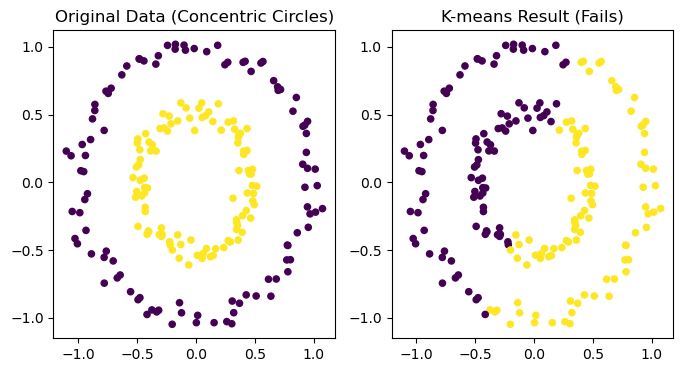

In [8]:
# 同心円状のデータを生成
X, y_true = make_circles(n_samples=200, factor=0.5, noise=0.05, random_state=0)

# K-meansが失敗することを確認
kmeans = KMeans(n_clusters=2, random_state=0, n_init='auto')
pred_kmeans = kmeans.fit_predict(X)

# データをプロット
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].set_title('Original Data (Concentric Circles)')
axes[0].scatter(X[:, 0], X[:, 1], c=y_true, s=20, cmap='viridis')

axes[1].set_title('K-means Result (Fails)')
axes[1].scatter(X[:, 0], X[:, 1], c=pred_kmeans, s=20, cmap='viridis')
plt.show()

## 3.2 スペクトラルクラスタリングクラスの実装

In [9]:
class SpectralClustering:
    def __init__(self, n_clusters=2, sigma=1.0):
        self.n_clusters = n_clusters
        self.sigma = sigma
        self.labels_ = None
        self.Y = None # スペクトル空間のデータ

    def fit_predict(self, X):
        # 類似度行列の構築 (RBFカーネル)
        A = np.zeros((X.shape[0], X.shape[0]))
        for i in range(X.shape[0]):
            for j in range(i + 1, X.shape[0]):
                dist_sq = np.sum((X[i] - X[j])**2)
                similarity = np.exp(-dist_sq / (2 * self.sigma**2))
                A[i, j] = similarity
                A[j, i] = similarity
        
        # 正規化ラプラシアンの構築
        D = np.diag(np.sum(A, axis=1))
        # ゼロ除算を避けるため、Dの逆数平方根を計算する際に微小値を加える
        D_inv_sqrt = np.linalg.inv(np.sqrt(D + 1e-10))
        L_sym = D_inv_sqrt @ A @ D_inv_sqrt
        
        # 3. 固有値分解
        eigenvalues, eigenvectors = np.linalg.eigh(L_sym)
        
        # 上位k個の固有ベクトルを取得 (eighは昇順で返すため、末尾からk個)
        U = eigenvectors[:, -self.n_clusters:]
        
        # 4. 行の正規化
        norm = np.linalg.norm(U, axis=1, keepdims=True)
        self.Y = U / (norm + 1e-10) # ゼロ除算防止
        
        # 5. K-meansによるクラスタリング
        kmeans = KMeans(n_clusters=self.n_clusters, n_init='auto', random_state=0)
        self.labels_ = kmeans.fit_predict(self.Y)
        
        return self.labels_

c:\Users\USER194\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


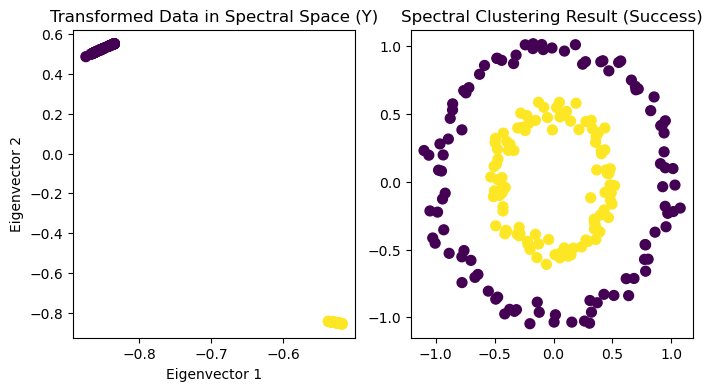

In [10]:
# スペクトラルクラスタリングを実行
# sigmaの値はデータに依存するため、調整が必要
spectral = SpectralClustering(n_clusters=2, sigma=0.1)
pred_spectral = spectral.fit_predict(X)

# スペクトル空間のデータを可視化
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].set_title('Transformed Data in Spectral Space (Y)')
axes[0].scatter(spectral.Y[:, 0], spectral.Y[:, 1], c=y_true, s=50, cmap='viridis')
axes[0].set_xlabel('Eigenvector 1')
axes[0].set_ylabel('Eigenvector 2')

axes[1].set_title('Spectral Clustering Result (Success)')
axes[1].scatter(X[:, 0], X[:, 1], c=pred_spectral, s=50, cmap='viridis')

plt.show()

## 4. まとめと考察

このノートブックでは、グラフ理論に基づくスペクトラルクラスタリング、特にNJWアルゴリズムについて学び、その実装を行いました。

*   スペクトラルクラスタリングは、データ間の関係性を**グラフ**として捉え、その<b>ラプラシアン行列のスペクトル（固有値・固有ベクトル）</b>を利用してクラスタリングを行います。
*   この手法の強力な点は、元々の特徴空間では線形分離不可能なデータ（例：同心円）を、固有ベクトルが張る**スペクトル空間に射影することで、線形分離可能な構造に変換**できることです。
*   可視化結果が示すように、スペクトル空間に変換されたデータは、K-meansのような単純なアルゴリズムでも容易にクラスタリングできるほど明確に分離されました。これにより、**任意の形状のクラスタを発見**することが可能になります。
*   一方で、性能はハイパーパラメータである**$\sigma$の値に敏感**であり、適切な値を選ぶ必要があります。また、類似度行列の計算と固有値分解は計算コストが高く（$O(N^2) \sim O(N^3)$）、大規模なデータセットへの適用には工夫が必要です。

スペクトラルクラスタリングは、その数学的な美しさと、複雑なデータ構造を捉える高い能力から、非常に重要なクラスタリング手法の一つとして位置づけられています。